# Imports

In [1]:
from ultralytics import YOLO
import cv2
import os
from PIL import Image, ImageFile, ImageDraw, ImageFont
import matplotlib.pyplot as plt
#from matplotlib import rcParams
import numpy as np
from googletrans import Translator
import deepl
import re
from difflib import SequenceMatcher
from concurrent.futures import ThreadPoolExecutor
import logging
from manga_ocr import MangaOcr
import textwrap
import warnings
import transformers
import contextlib

translator = Translator()
translator_deepl = deepl.Translator(auth_key="YOUR-API-KEY")

#plt.rcParams['font.family'] = 'IPAGothic'

# Suppress verbose output from transformers
transformers.logging.set_verbosity_error()
logging.getLogger("transformers").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set general logging level
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### Step 1. Load Yolo and Run Inference on manga page

In [2]:
# Configure image loading to handle potentially corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True  # allow truncated image loading
# Set up logging configuration with timestamp and log level
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def reload_and_save_images(folder_path):
    """
    Reloads and resaves all images in a folder to ensure they are properly formatted.
    
    This function:
    1. Scans a directory for image files
    2. Attempts to reload each image
    3. Converts images to RGB format
    4. Resaves them to fix any corruption or formatting issues
    
    Args:
        folder_path (str): Path to the directory containing images
        
    Returns:
        None
    """
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, filename)
            try:
                img = Image.open(path)
                img = img.convert("RGB")  # force full load
                img.save(path)  # overwrite with cleaned file
            except Exception as e:
                print(f"Skipping {filename}: {e}")

# Process all images in the 'images' directory
reload_and_save_images('images')

# Initialize YOLO model for text detection
model = YOLO("best.pt")

# Specify the path to the manga image to process
image_path = "images/YOUR-IMAGE.jpg"
# Run YOLO inference on the image to detect text regions
results = model(image_path)

# Display the detection results
results[0].show()
# Read the image using OpenCV for further processing
image = cv2.imread(image_path)


image 1/1 c:\Users\handw\Documents\Portfolio-FTDS\manga_translator_project\images\onepiece_13.jpg: 640x448 12 bubbles, 10 texts, 114.5ms
Speed: 3.5ms preprocess, 114.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


### Preprocess images

In [3]:
def preprocess_image(image_path):
    """
    Preprocesses an image for better text detection and OCR.
    
    This function:
    1. Converts the image to grayscale
    2. Applies median blur to reduce noise
    3. Applies adaptive thresholding to enhance text contrast
    
    Args:
        image_path (str): Path to the input image
        
    Returns:
        numpy.ndarray: Preprocessed image in binary format
    """
    # Read image in grayscale mode for better text detection
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply median blur to reduce noise while preserving edges
    image = cv2.medianBlur(image, 3)
    # Apply adaptive thresholding to convert to binary image
    # Uses Gaussian-weighted mean with block size 11 and constant 2
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return image

# Process the input image through the preprocessing pipeline
preprocessed_image = preprocess_image(image_path)

### Sort bubbles by reading order

In [4]:
def sort_bubbles(boxes):
    """
    Sorts text bubbles in reading order (top-to-bottom, right-to-left).
    
    This function sorts the bounding boxes of text bubbles in a way that matches
    the natural reading order of manga (typically top-to-bottom, right-to-left).
    
    Args:
        boxes (list or numpy.ndarray): List of bounding boxes in format [x1, y1, x2, y2]
        
    Returns:
        list: Sorted list of bounding boxes in reading order
    """
    # Sort boxes by:
    # 1. Vertical position (y-coordinate) divided by 50 to group into rows
    # 2. Horizontal position (x-coordinate) in reverse order for right-to-left reading
    return sorted(boxes, key=lambda b: (int(b[1] // 50), -int(b[0])))

# Sort the detected text bubbles from YOLO results in reading order
sorted_boxes = sort_bubbles(results[0].boxes.xyxy)

### Detecting_region

In [5]:
def determine_region_type(box, image, class_id):
    """
    Determine region type based on the model's class prediction.
    
    This function maps the YOLO model's class predictions to specific manga region types.
    It helps identify different types of text containers in manga pages.
    
    Args:
        box (tuple or list): Bounding box coordinates [x1, y1, x2, y2]
        image (numpy.ndarray): The input image (not used in current implementation)
        class_id (int): The class ID from the model:
            - 0: Speech bubble
            - 1: Narration box
            - 2: Other elements
            - 3: Standalone text
            - 4: UI elements
    
    Returns:
        str: String indicating the region type, or "unknown" if class_id is not recognized
    """
    # Define mapping between YOLO class IDs and manga region types
    class_to_type = {
        0: "bubble",      # Speech bubbles containing dialogue
        1: "narration",   # Rectangular narration boxes
        2: "other",       # Other manga elements
        3: "text",        # Standalone text elements
        4: "ui"          # User interface elements
    }
    
    # Return the corresponding region type or "unknown" if class_id not found
    return class_to_type.get(class_id, "unknown")

### OCR Each Bubble

2025-04-25 01:48:27.211 | INFO     | manga_ocr.ocr:__init__:16 - Loading OCR model from kha-white/manga-ocr-base
2025-04-25 01:48:31.661 | INFO     | manga_ocr.ocr:__init__:28 - Using CPU
2025-04-25 01:48:32.145 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready


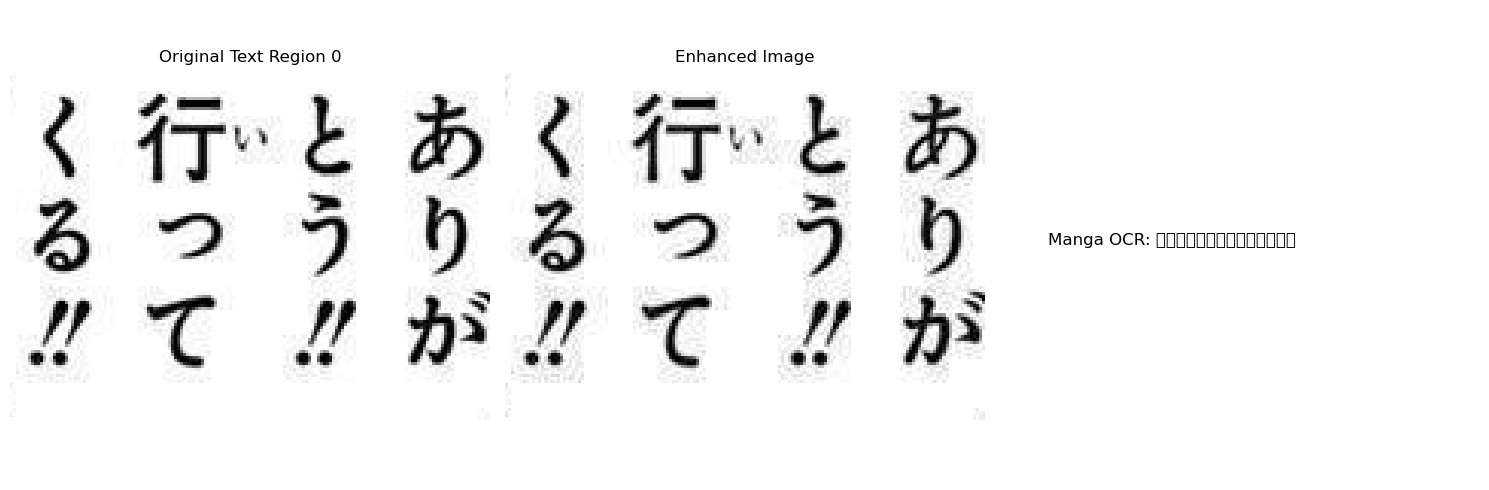

Text Region 0 Manga OCR result: ありがとう！！行ってくる！！


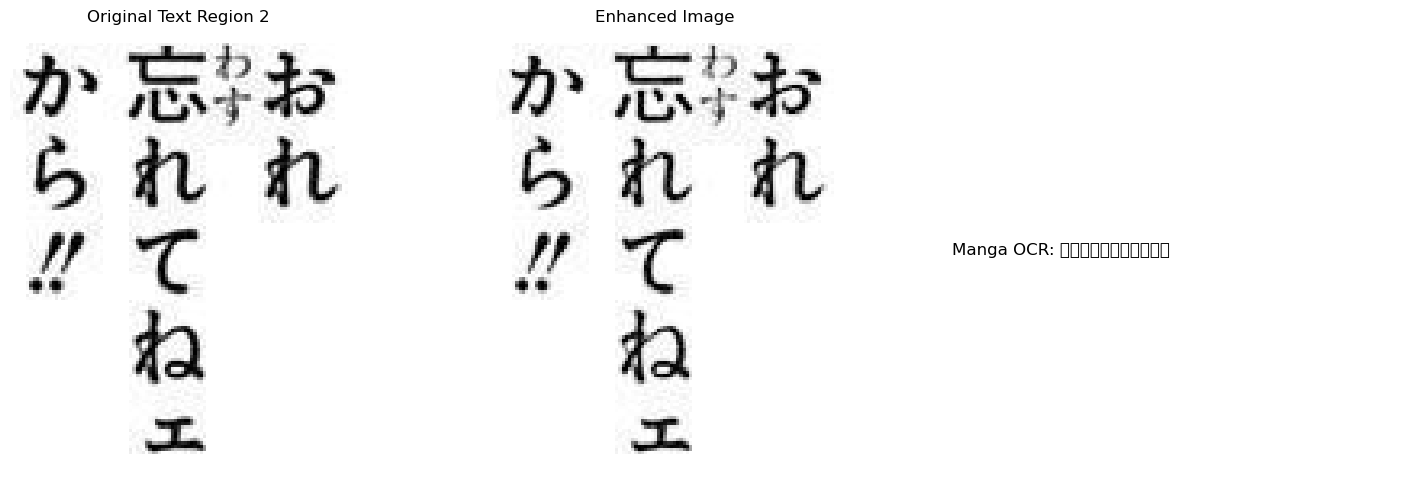

Text Region 2 Manga OCR result: おれ忘れてねェから！！


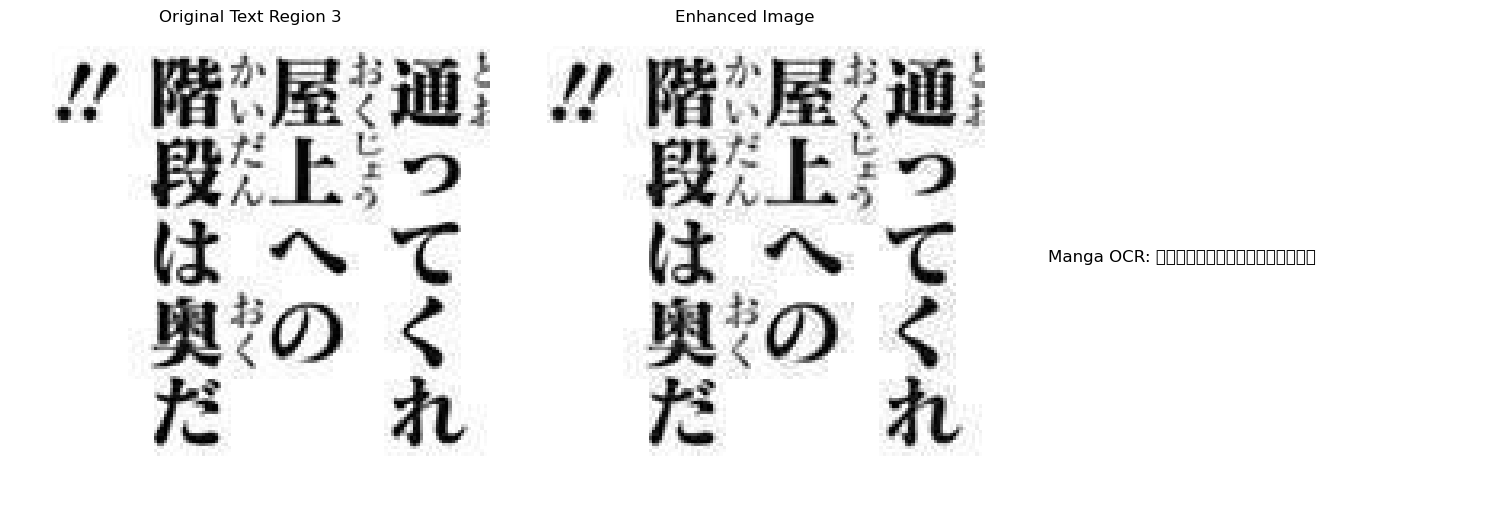

Text Region 3 Manga OCR result: 通ってくれ屋上への階段は奥だ！！


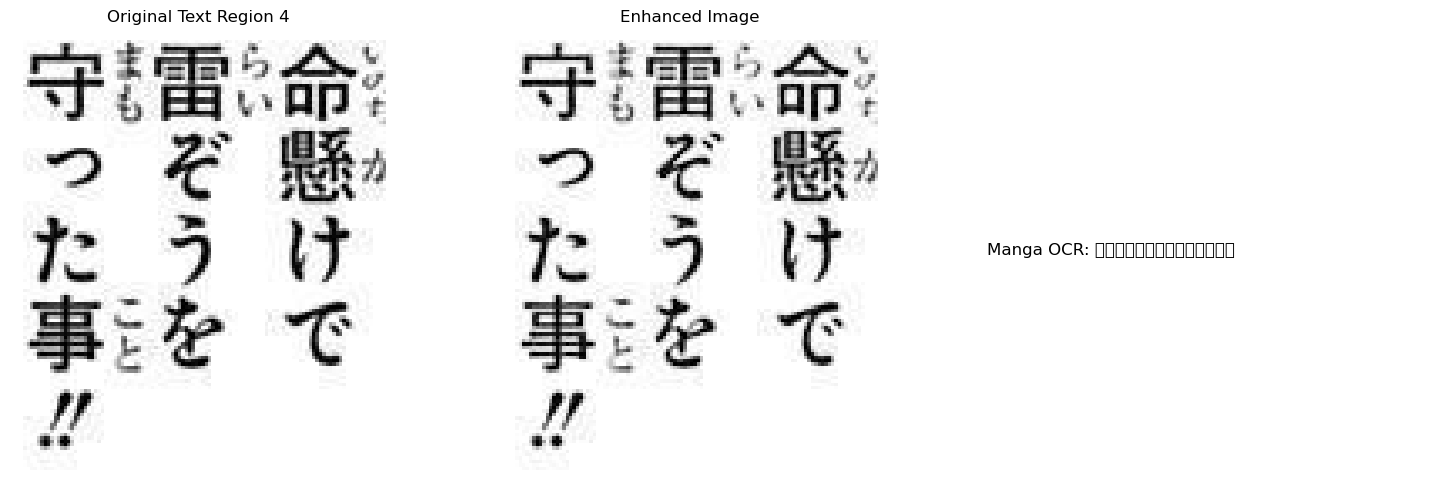

Text Region 4 Manga OCR result: 命懸けで雷ぞうを守った事！！


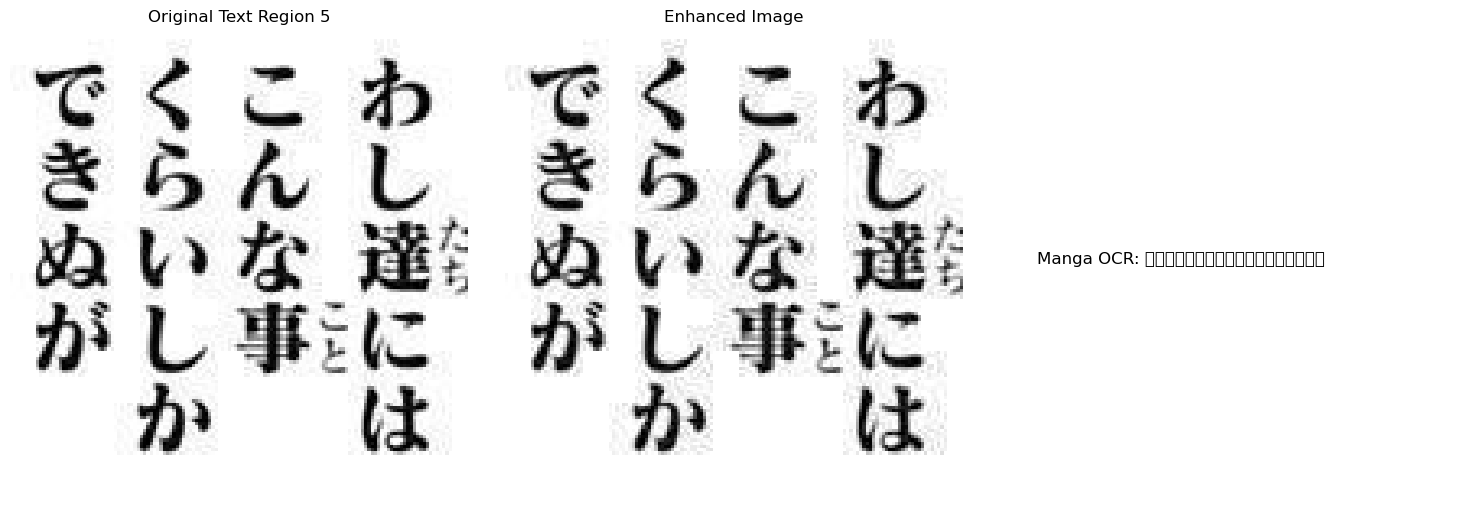

Text Region 5 Manga OCR result: わし達にはこんな事くらいしかできぬが


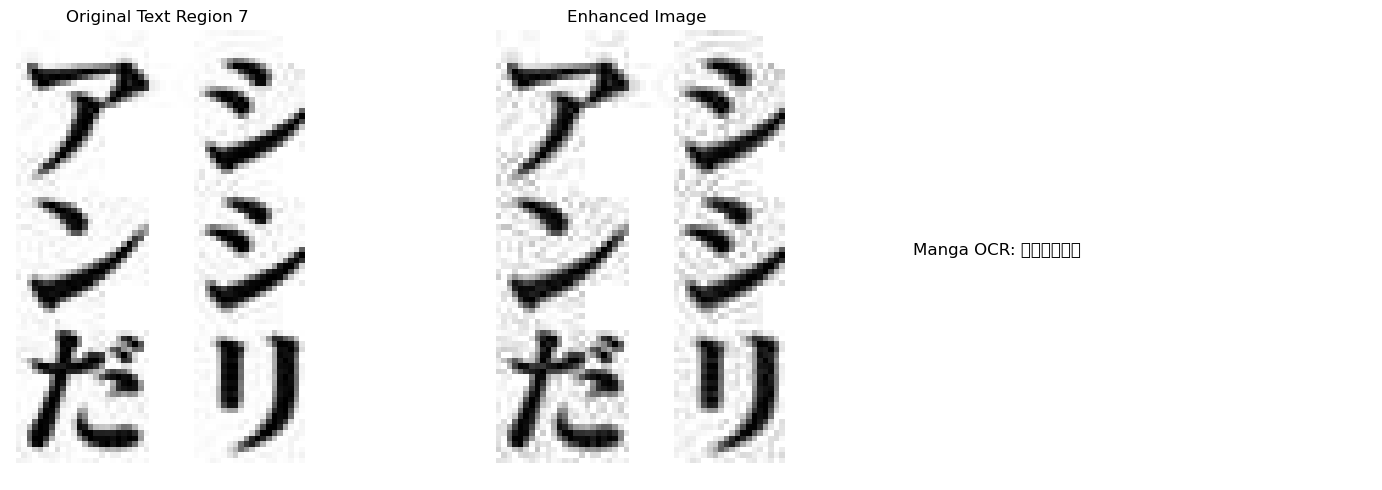

Text Region 7 Manga OCR result: シンリアンだ


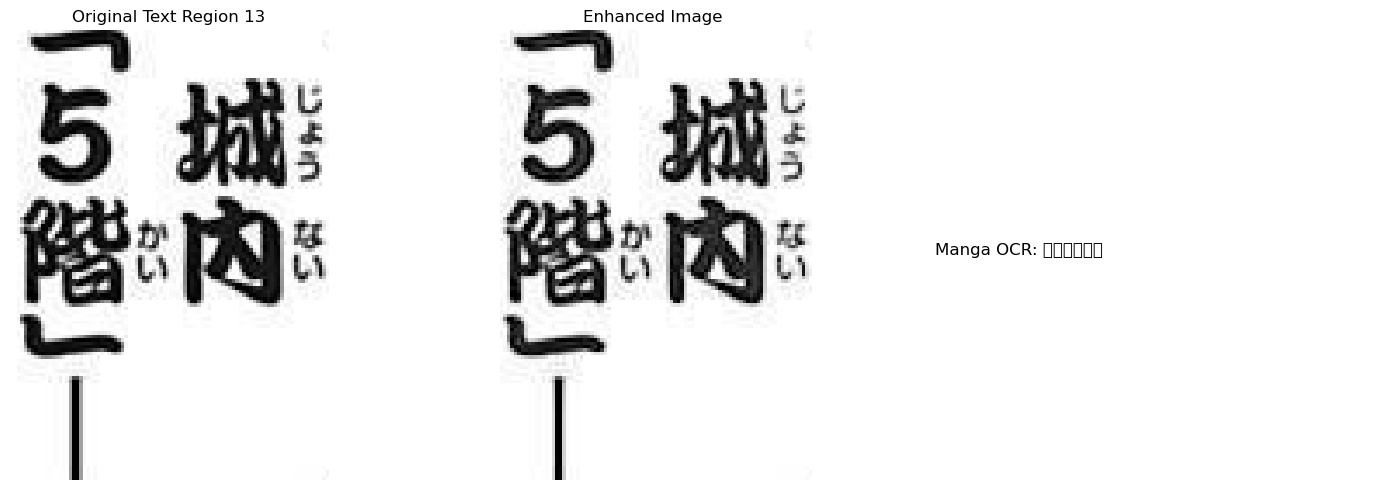

Text Region 13 Manga OCR result: 城内「５階」


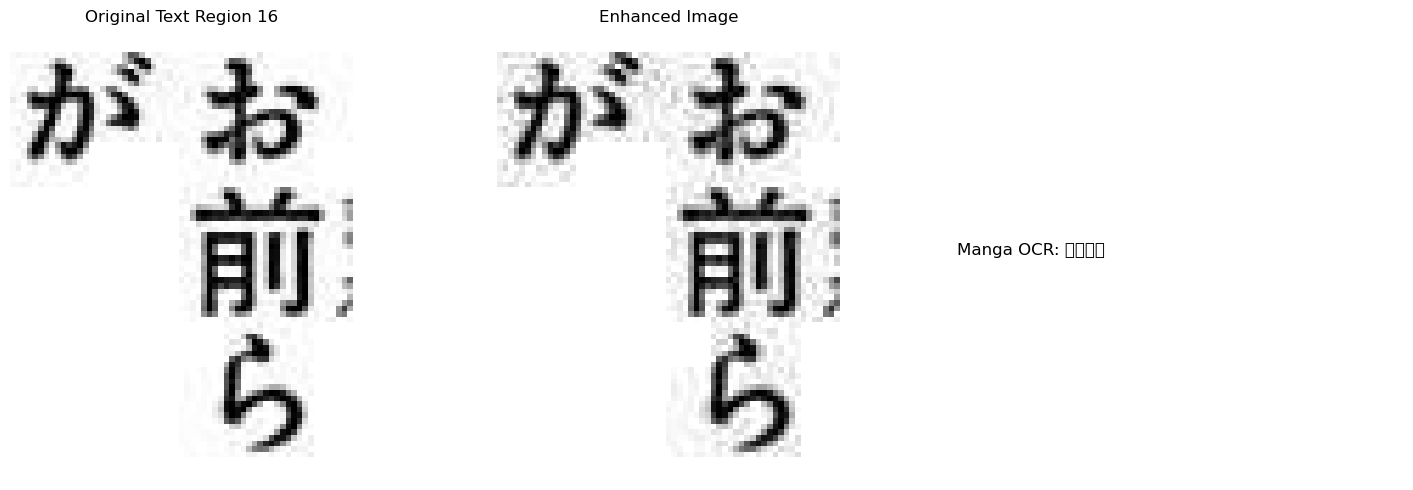

Text Region 16 Manga OCR result: お前らが


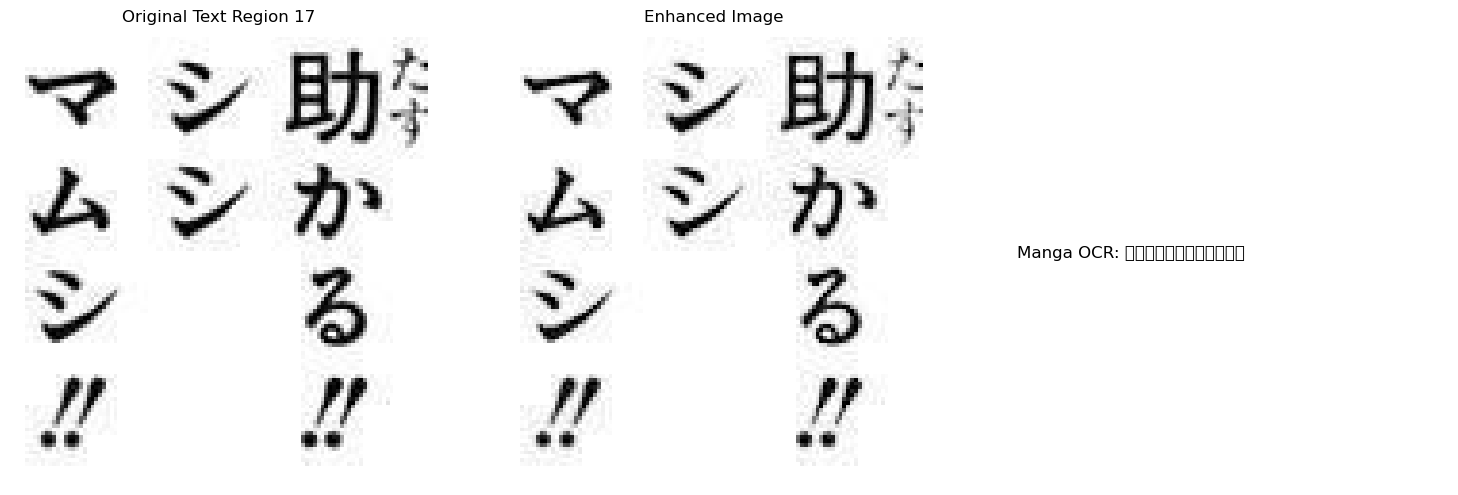

Text Region 17 Manga OCR result: 助かる！！シンマムシ！！


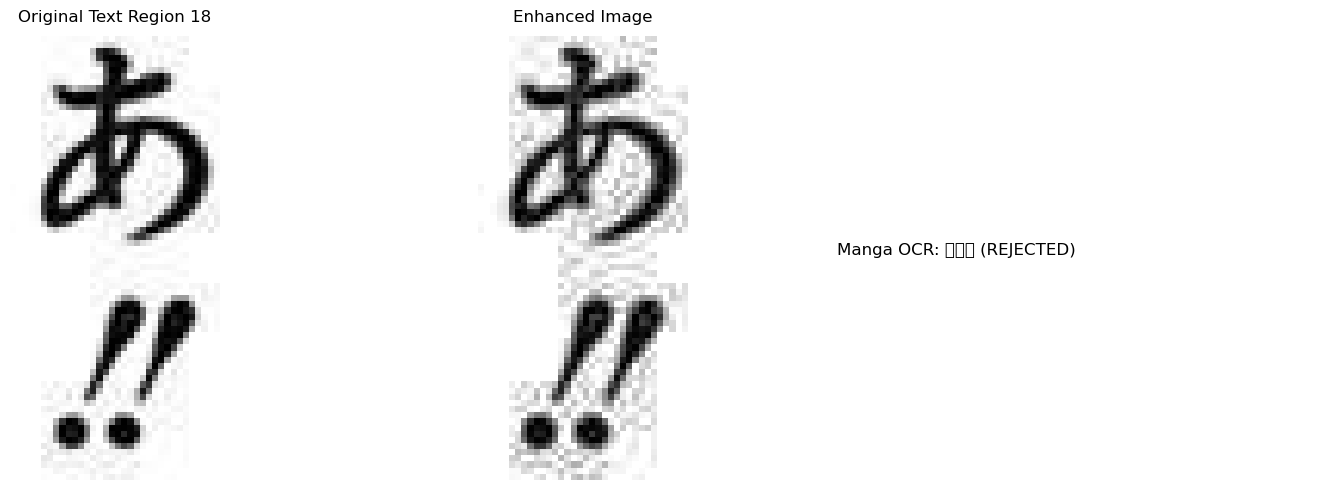

Text Region 18 Manga OCR result: あ！！
Rejecting text region 18: Low confidence OCR result

Detected Text Regions:
0. 城内「５階」
1. わし達にはこんな事くらいしかできぬが
2. 通ってくれ屋上への階段は奥だ！！
3. おれ忘れてねェから！！
4. 命懸けで雷ぞうを守った事！！
5. 助かる！！シンマムシ！！
6. ありがとう！！行ってくる！！
7. シンリアンだ
8. お前らが


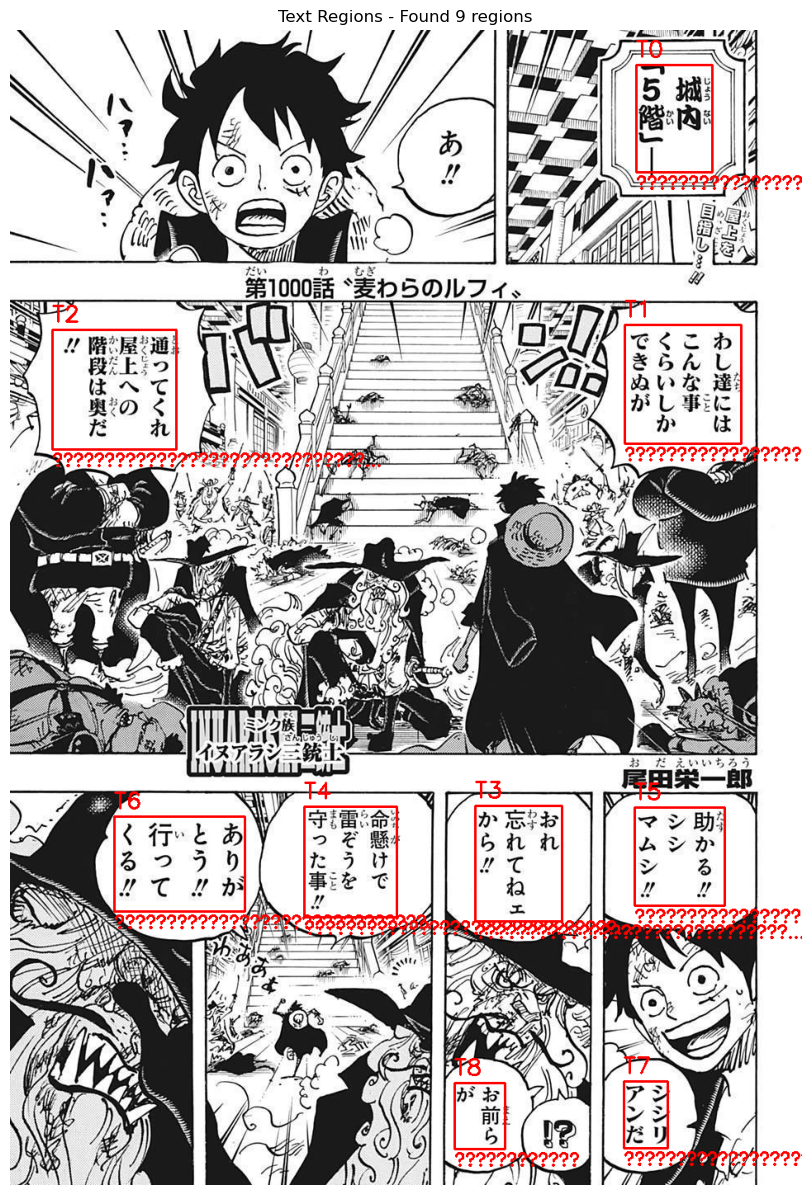

In [6]:
def enhance_text_region(image_region):
    """
    Enhance text clarity in an image region before OCR.
    
    This function applies a series of image processing techniques to improve
    text visibility and OCR accuracy in manga panels.
    
    Args:
        image_region: The image region to enhance
        
    Returns:
        Enhanced image region
    """
    # Convert to grayscale if needed (for color images)
    gray = cv2.cvtColor(image_region, cv2.COLOR_BGR2GRAY) if len(image_region.shape) == 3 else image_region
    
    # Apply adaptive thresholding to create binary image
    # Uses Gaussian-weighted mean with block size 11 and constant 2
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 11, 2)
    
    # Apply non-local means denoising to reduce noise while preserving edges
    denoised = cv2.fastNlMeansDenoising(binary, None, 10, 7, 21)
    
    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    # to enhance local contrast while preventing noise amplification
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)  # Apply to original grayscale for better results
    
    return enhanced

def validate_ocr_result(text, image_region):
    """
    Validate OCR results to filter out hallucinations or low-confidence detections.
    
    This function performs multiple checks to ensure the OCR result is reliable:
    1. Text length validation
    2. Image clarity assessment
    3. Contrast analysis
    4. Text density verification
    
    Args:
        text: The OCR text result
        image_region: The image region that was processed
        
    Returns:
        bool: True if the text is likely valid, False otherwise
    """
    # 1. Check if text is too short or empty
    if not text or len(text.strip()) < 2:
        return False
    
    # 2. Calculate image clarity metrics using Laplacian variance
    gray = cv2.cvtColor(image_region, cv2.COLOR_BGR2GRAY) if len(image_region.shape) == 3 else image_region
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # If image is very blurry, reject the text
    if laplacian_var < 50:  # Threshold may need adjustment
        return False
    
    # 3. Check contrast in the region
    min_val, max_val, _, _ = cv2.minMaxLoc(gray)
    contrast = max_val - min_val
    
    # If contrast is very low, reject the text
    if contrast < 30:  # Threshold may need adjustment
        return False
    
    # 4. Check for reasonable text density
    text_density = np.count_nonzero(gray < 128) / gray.size
    
    # If there's very little dark pixels (potential text), reject
    if text_density < 0.05:
        return False
    
    return True

def verify_japanese_text(text):
    """
    Verify if the detected text is likely valid Japanese.
    
    This function checks for:
    1. Presence of Japanese characters
    2. Reasonable character distribution
    3. Common OCR errors
    
    Args:
        text: The OCR text result
        
    Returns:
        bool: True if the text is likely valid Japanese, False otherwise
    """
    # Check if text contains Japanese characters
    # Unicode ranges for Japanese characters:
    # \u3000-\u303F: CJK punctuation and symbols
    # \u3040-\u309F: Hiragana
    # \u30A0-\u30FF: Katakana
    # \u4E00-\u9FFF: Kanji
    japanese_chars = re.findall(r'[\u3000-\u303F\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF]', text)
    if len(japanese_chars) < len(text) * 0.5:
        return False
    
    # Check for common OCR errors (repeated characters)
    for char in set(text):
        if text.count(char) > len(text) * 0.7:  # If one character is >70% of the text
            return False
    
    return True

# Initialize MangaOCR model
mocr = MangaOcr()

def process_text_regions(results, image):
    """
    Process only class 3 (text) detections from the model.
    
    This function:
    1. Extracts text regions from YOLO detections
    2. Enhances each region for better OCR
    3. Validates OCR results
    4. Creates debug visualizations
    5. Returns valid text regions with their coordinates
    
    Args:
        results: YOLO detection results
        image: Original input image
        
    Returns:
        list: List of dictionaries containing text regions and their metadata
    """
    text_regions = []
    
    # Process only class 3 (text) detections
    for i, (box, cls_id) in enumerate(zip(results[0].boxes.xyxy, results[0].boxes.cls)):
        cls_id = int(cls_id)
        
        # Only process text class (class 3)
        if cls_id != 3:
            continue
            
        # Extract coordinates and crop the region
        x1, y1, x2, y2 = map(int, box)
        cropped = image[y1:y2, x1:x2]
        
        # Store original cropped image for display
        original_crop = cropped.copy()
        
        # Enhance the image for better OCR
        enhanced_crop = enhance_text_region(cropped)
        
        # Convert to PIL image for OCR
        pil_crop = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        
        # Get OCR result
        text = mocr(pil_crop)
        
        # Validate the OCR result
        is_valid = validate_ocr_result(text, cropped) and verify_japanese_text(text)
        
        # Create debug directory if it doesn't exist
        os.makedirs("debug_text", exist_ok=True)
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        # Original cropped image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original_crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Text Region {i}")
        plt.axis('off')
        
        # Enhanced image
        plt.subplot(1, 3, 2)
        plt.imshow(enhanced_crop, cmap='gray')
        plt.title("Enhanced Image")
        plt.axis('off')
        
        # OCR result
        plt.subplot(1, 3, 3)
        result_text = f"Manga OCR: {text if text else 'No text detected'}"
        if not is_valid:
            result_text += " (REJECTED)"
        plt.text(0.1, 0.5, result_text, fontsize=12, wrap=True)
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join("debug_text", f"result_{i}.png"))
        plt.show()
        
        print(f"Text Region {i} Manga OCR result: {text}")
        if not is_valid:
            print(f"Rejecting text region {i}: Low confidence OCR result")
            continue
        
        text_regions.append({
            'text': text,
            'coords': (x1, y1, x2, y2),
            'class': cls_id
        })
    
    return text_regions

# Main processing code
text_regions = process_text_regions(results, image)

# Sort by vertical position (top to bottom)
text_regions.sort(key=lambda x: x['coords'][1])

# Print results
print("\nDetected Text Regions:")
for i, region in enumerate(text_regions):
    print(f"{i}. {region['text']}")

# Final visualization
final_vis_image = image.copy()

# Draw all valid text regions
for i, region in enumerate(text_regions):
    x1, y1, x2, y2 = region['coords']
    
    # Draw text regions in red
    color = (0, 0, 255)  # Red for text
    label = f"T{i}"
    
    # Draw bounding box and label
    cv2.rectangle(final_vis_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(final_vis_image, label, (x1, y1-10), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    # Add text preview
    preview = region['text'][:10] + "..." if len(region['text']) > 10 else region['text']
    cv2.putText(final_vis_image, preview, (x1, y2+20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

# Display final visualization
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(final_vis_image, cv2.COLOR_BGR2RGB))
plt.title(f"Text Regions - Found {len(text_regions)} regions")
plt.axis('off')
plt.savefig('final_text_detection.png', dpi=300)
plt.show()

### OCR Cleanup

In [7]:
def clean_ocr_text(text):
    """
    Clean OCR text by removing non-Japanese/non-English characters and normalizing spaces.
    
    This function:
    1. Removes unwanted characters while preserving Japanese, English, and basic punctuation
    2. Merges separated kanji words
    3. Normalizes whitespace
    
    Args:
        text (str): Raw OCR text to clean
        
    Returns:
        str: Cleaned and normalized text
    """
    # Remove non-Japanese/non-English characters
    # Unicode ranges:
    # \u3000-\u303F: CJK punctuation and symbols
    # \u3040-\u309F: Hiragana
    # \u30A0-\u30FF: Katakana
    # \u4E00-\u9FFF: Kanji
    # \uFF00-\uFFEF: Full-width characters
    text = re.sub(r'[^\u3000-\u303F\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\uFF00-\uFFEFa-zA-Z0-9\s.,!?\'\"-]', '', text)
    # Merge separated kanji words (e.g., 畑 仕事 -> 畑仕事)
    text = re.sub(r'(?<=[\u4E00-\u9FFF]) (?=[\u4E00-\u9FFF])', '', text)
    # Normalize spaces (replace multiple spaces with single space)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def split_japanese_sentences(text):
    """
    Split Japanese text into sentences based on punctuation.
    
    This function splits text at Japanese sentence endings (。！？)
    and adds newlines for better readability.
    
    Args:
        text (str): Japanese text to split
        
    Returns:
        str: Text with newlines after each sentence
    """
    return re.sub(r'([。！？])', r'\1\n', text).strip()

# Clean and format the extracted text from text regions
cleaned_text_regions = []

# Process all text regions
for i, region in enumerate(text_regions):
    # Clean the OCR text
    cleaned_text = clean_ocr_text(region['text'])
    # Split into sentences
    formatted_text = split_japanese_sentences(cleaned_text)
    
    # Only keep non-empty text regions
    if formatted_text.strip():
        cleaned_text_regions.append({
            'id': i,
            'text': formatted_text,
            'coords': region['coords']
        })
        print(f"Text Region {i} (cleaned):\n{formatted_text}\n")

# Group by region to avoid counting split sentences as separate regions
region_to_sentences = {}

# Process each cleaned region
for region in cleaned_text_regions:
    # Split into individual sentences
    sentences = region['text'].split('\n')
    # Filter out empty sentences
    valid_sentences = [s for s in sentences if s.strip()]
    
    # Store valid sentences with their coordinates
    if valid_sentences:
        region_to_sentences[region['id']] = {
            'sentences': valid_sentences,
            'coords': region['coords']
        }

# Print text organized by region
print("=== TEXT BY REGION ===")
for region_id, region_data in region_to_sentences.items():
    text = "\n".join(region_data['sentences'])
    print(f"Region {region_id}:\n{text}\n")

# Prepare for deduplication
all_sentences = []
for region_id, region_data in region_to_sentences.items():
    for sentence in region_data['sentences']:
        all_sentences.append((region_id, sentence))

def is_similar(a, b, threshold=0.8):
    """
    Check if two strings are similar based on sequence matching.
    
    Uses difflib's SequenceMatcher to compare strings and determine
    if they are likely duplicates or variations of the same text.
    
    Args:
        a (str): First string to compare
        b (str): Second string to compare
        threshold (float): Similarity threshold (0.0 to 1.0)
        
    Returns:
        bool: True if strings are similar enough to be considered duplicates
    """
    return SequenceMatcher(None, a, b).ratio() > threshold

# Deduplicate sentences
unique_sentences = []

# Compare each sentence with previously seen sentences
for i, (region_id, sentence) in enumerate(all_sentences):
    # Check if this sentence is similar to any we've seen before
    is_duplicate = False
    for _, existing_sentence in unique_sentences:
        if is_similar(sentence, existing_sentence):
            is_duplicate = True
            break
    
    # Only add if not a duplicate
    if not is_duplicate:
        unique_sentences.append((region_id, sentence))

# Create a comprehensive text extraction result
all_extracted_text = {
    'regions': region_to_sentences,
    'unique_sentences': unique_sentences,
}

# Print a summary of the extraction results
print("=== TEXT EXTRACTION SUMMARY ===")
print(f"Total regions with text: {len(region_to_sentences)}")
print(f"Total unique sentences: {len(unique_sentences)}")

# Print all unique sentences with their region numbers
print("\nAll extracted text combined:")
for region_id, sentence in unique_sentences:
    print(f"[Region {region_id}] {sentence}")

Text Region 0 (cleaned):
城内「５階」

Text Region 1 (cleaned):
わし達にはこんな事くらいしかできぬが

Text Region 2 (cleaned):
通ってくれ屋上への階段は奥だ！
！

Text Region 3 (cleaned):
おれ忘れてねェから！
！

Text Region 4 (cleaned):
命懸けで雷ぞうを守った事！
！

Text Region 5 (cleaned):
助かる！
！
シンマムシ！
！

Text Region 6 (cleaned):
ありがとう！
！
行ってくる！
！

Text Region 7 (cleaned):
シンリアンだ

Text Region 8 (cleaned):
お前らが

=== TEXT BY REGION ===
Region 0:
城内「５階」

Region 1:
わし達にはこんな事くらいしかできぬが

Region 2:
通ってくれ屋上への階段は奥だ！
！

Region 3:
おれ忘れてねェから！
！

Region 4:
命懸けで雷ぞうを守った事！
！

Region 5:
助かる！
！
シンマムシ！
！

Region 6:
ありがとう！
！
行ってくる！
！

Region 7:
シンリアンだ

Region 8:
お前らが

=== TEXT EXTRACTION SUMMARY ===
Total regions with text: 9
Total unique sentences: 12

All extracted text combined:
[Region 0] 城内「５階」
[Region 1] わし達にはこんな事くらいしかできぬが
[Region 2] 通ってくれ屋上への階段は奥だ！
[Region 2] ！
[Region 3] おれ忘れてねェから！
[Region 4] 命懸けで雷ぞうを守った事！
[Region 5] 助かる！
[Region 5] シンマムシ！
[Region 6] ありがとう！
[Region 6] 行ってくる！
[Region 7] シンリアンだ
[Region 8] お前らが


### Merge and Translate

In [8]:
# Configure logging with warning level to reduce noise
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize DeepL translator with error handling
try:
    translator_deepl = deepl.Translator("a745ca2a-a4eb-45d9-a20e-a19c22a56240:fx")
except Exception as e:
    logging.error(f"Failed to initialize DeepL translator: {e}")
    # Fallback to a placeholder translator for testing
    class PlaceholderTranslator:
        def translate_text(self, text, source_lang, target_lang):
            class Result:
                def __init__(self, text):
                    self.text = f"[TRANSLATION: {text}]"
            return Result(text)
    translator_deepl = PlaceholderTranslator()

def manga_style_formatting(text):
    """
    Apply universal manga-specific formatting rules.
    
    This function handles:
    1. Japanese honorifics
    2. Sound effects (SFX)
    3. Character names
    4. Common expressions
    5. Emphasis and punctuation
    
    Args:
        text (str): Text to format
        
    Returns:
        str: Formatted text with manga-style conventions
    """
    # Common Japanese honorifics and universal manga terms
    manga_terms = {
        'sama': '-sama',  # Highly respectful
        'san': '-san',    # Polite
        'kun': '-kun',    # Familiar, usually for young males
        'chan': '-chan',  # Endearing, usually for young females or close friends
        'sensei': '-sensei',  # Teacher/Master/Doctor
        'senpai': '-senpai',  # Senior
        'kouhai': '-kouhai',  # Junior
        'dono': '-dono',  # Very formal, archaic
        'shi': '-shi',    # Formal, business-like
    }
    
    # Universal manga sound effects categories
    sfx_categories = {
        'ドドド|ゴゴゴ|ドンドン': '*RUMBLE*',  # Rumbling sounds
        'バキッ|バキバキ': '*CRACK*',          # Breaking sounds
        'ガチャ|カチャ': '*CLICK*',            # Mechanical sounds
        'ザー|ザァ': '*WHOOSH*',              # Wind/movement sounds
        'ドン|バン': '*BAM*',                  # Impact sounds
        'シーン': '*SILENCE*',                 # Silence
        'キラキラ': '*SPARKLE*',               # Sparkling
        'ニコ': '*SMILE*',                     # Smiling
        'ハァハァ': '*PANT*',                  # Breathing
        'ドキドキ': '*THUMP*'                  # Heartbeat
    }
    
    # Common character names mapping
    character_names = {
        'カイドウ': 'Kaido',
        'モンキー・ロ・ルフィ': 'Monkey D. Luffy',
        '海賊王': 'Pirate King'
    }
    
    # Format text
    formatted_text = text
    
    # Preserve character names
    for jp, en in character_names.items():
        formatted_text = formatted_text.replace(jp, en)
    
    # Handle common manga expressions
    formatted_text = formatted_text.replace('お前', 'you')
    formatted_text = formatted_text.replace('おれ', 'I')
    
    # Handle emphasis and punctuation
    formatted_text = re.sub(r'(!+)', r'!\1', formatted_text)
    formatted_text = formatted_text.replace('...', '…')
    formatted_text = re.sub(r'\?+!+|\!+\?+', '?!', formatted_text)
    
    # Handle shouting (all caps with specific punctuation)
    if '!' in formatted_text:
        formatted_text = formatted_text.upper()
    
    return formatted_text

def clean_and_translate_text(text, context=None):
    """
    Clean and translate text with universal manga context.
    
    This function:
    1. Cleans the input text
    2. Translates using DeepL
    3. Applies manga-style formatting
    4. Post-processes for readability
    
    Args:
        text (str): Text to translate
        context (dict, optional): Additional context for translation
        
    Returns:
        str: Translated and formatted text
    """
    # Remove standalone punctuation marks
    if text.strip() in ['！', '。', '、', '．．．', '？']:
        return ""
    
    # Clean the text before translation
    cleaned_text = text.strip()
    
    try:
        # Translate without formality parameter
        translation = translator_deepl.translate_text(
            cleaned_text,
            source_lang='JA',
            target_lang='EN-US',
            preserve_formatting=True
        ).text
        
        # Apply manga-style formatting
        translation = manga_style_formatting(translation)
        
        # Post-process for readability
        translation = re.sub(r'\s+([!?.,])', r'\1', translation)  # Fix punctuation spacing
        translation = re.sub(r'[\s\n]+', ' ', translation).strip()  # Clean up whitespace
        
        logging.info(f"Translated: {cleaned_text} -> {translation}")
        return translation
    except Exception as e:
        logging.error(f"Translation failed for {cleaned_text}: {e}")
        return ""

def post_process_translation(translation, text_type=None):
    """
    Apply final formatting based on text type.
    
    This function handles:
    1. Sound effects formatting
    2. Emphasis formatting
    3. General text formatting
    
    Args:
        translation (str): Translated text to process
        text_type (str, optional): Type of text (sfx, emphasis, etc.)
        
    Returns:
        str: Post-processed translation
    """
    # Detect text type if not provided
    if text_type is None:
        if bool(re.search(r'[ドゴバキガ]{2,}', translation)):
            text_type = "sfx"
        elif '!' in translation or '?' in translation:
            text_type = "emphasis"
    
    # Apply formatting based on type
    if text_type == "sfx":
        return f"*{translation.upper()}*"
    elif text_type == "emphasis":
        if '!' in translation and '?' in translation:
            return translation.upper() + "?!"
        elif '!' in translation:
            return translation.upper()
        else:
            return translation
    
    return translation

# Get all unique sentences to translate
sentences_to_translate = []
for region_id, sentence in unique_sentences:
    # Skip standalone punctuation but keep sound effects
    if sentence.strip() not in ['！', '。', '、', '．．．'] or bool(re.search(r'[ドゴバキガ]{2,}', sentence)):
        sentences_to_translate.append(sentence)

print(f"Found {len(sentences_to_translate)} unique text segments to translate")
for i, text in enumerate(sentences_to_translate):
    print(f"{i+1}. {text}")

# Translate all unique sentences
translated_sentences = []
for text in sentences_to_translate:
    # Detect if text is a sound effect
    is_sfx = bool(re.search(r'[ドゴバキガ]{2,}', text))
    
    # Translate and post-process
    translation = clean_and_translate_text(text)
    if translation:
        # Apply final formatting based on text type
        processed_translation = post_process_translation(translation, "sfx" if is_sfx else None)
        translated_sentences.append((text, processed_translation))

# Display translation results
print("\n=== TRANSLATION RESULTS ===\n")
for original, translation in translated_sentences:
    print(f"Original: {original}")
    print(f"Translation: {translation}")
    print()

# Create a mapping from original text to translation
translation_map = {original: translation for original, translation in translated_sentences}

# Create a mapping from region to translation
region_translations = {}
for region_id, region_data in region_to_sentences.items():
    sentences = region_data['sentences']
    translations = []
    
    for sentence in sentences:
        if not sentence.strip():
            continue
            
        # Keep sound effects even if they're just symbols
        is_sfx = bool(re.search(r'[ドゴバキガ]{2,}', sentence))
        if not is_sfx and sentence.strip() in ['！', '。', '、', '．．．']:
            continue
            
        # Find the exact match or most similar text
        if sentence in translation_map:
            translations.append(translation_map[sentence])
        else:
            # Find the most similar text
            best_match = None
            best_score = 0
            
            for original in translation_map.keys():
                score = SequenceMatcher(None, sentence, original).ratio()
                if score > best_score and score > 0.8:
                    best_score = score
                    best_match = original
            
            if best_match:
                translations.append(translation_map[best_match])
    
    if translations:
        # Join translations and apply final manga-style formatting
        combined_translation = ' '.join(translations)
        
        # Detect if this is a sound effect region
        is_sfx_region = any(bool(re.search(r'[ドゴバキガ]{2,}', s)) for s in sentences)
        
        # Apply final formatting
        final_translation = post_process_translation(
            combined_translation,
            "sfx" if is_sfx_region else None
        )
        
        region_translations[region_id] = {
            'original': "\n".join(sentences),
            'translation': final_translation,
            'coords': region_data['coords']
        }

print(f"\nPrepared translations for {len(region_translations)} regions")

# Print the translations by region
print("\n=== TRANSLATIONS BY REGION ===\n")
for region_id, data in region_translations.items():
    print(f"Region {region_id}:")
    print(f"Original: {data['original']}")
    print(f"Translation: {data['translation']}")
    print()

2025-04-25 01:48:40,175 - INFO - Request to DeepL API method=POST url=https://api-free.deepl.com/v2/translate


Found 11 unique text segments to translate
1. 城内「５階」
2. わし達にはこんな事くらいしかできぬが
3. 通ってくれ屋上への階段は奥だ！
4. おれ忘れてねェから！
5. 命懸けで雷ぞうを守った事！
6. 助かる！
7. シンマムシ！
8. ありがとう！
9. 行ってくる！
10. シンリアンだ
11. お前らが


2025-04-25 01:48:40,849 - INFO - DeepL API response status_code=200 url=https://api-free.deepl.com/v2/translate
2025-04-25 01:48:40,851 - INFO - Translated: 城内「５階」 -> Inside the castle "5th floor
2025-04-25 01:48:40,852 - INFO - Request to DeepL API method=POST url=https://api-free.deepl.com/v2/translate
2025-04-25 01:48:41,156 - INFO - DeepL API response status_code=200 url=https://api-free.deepl.com/v2/translate
2025-04-25 01:48:41,157 - INFO - Translated: わし達にはこんな事くらいしかできぬが -> This is the least we can do.
2025-04-25 01:48:41,157 - INFO - Request to DeepL API method=POST url=https://api-free.deepl.com/v2/translate
2025-04-25 01:48:41,404 - INFO - DeepL API response status_code=200 url=https://api-free.deepl.com/v2/translate
2025-04-25 01:48:41,405 - INFO - Translated: 通ってくれ屋上への階段は奥だ！ -> COME THROUGH, THE STAIRS TO THE ROOFTOP ARE AT THE BACK!!
2025-04-25 01:48:41,405 - INFO - Request to DeepL API method=POST url=https://api-free.deepl.com/v2/translate
2025-04-25 01:48:41,641 - INFO -


=== TRANSLATION RESULTS ===

Original: 城内「５階」
Translation: Inside the castle "5th floor

Original: わし達にはこんな事くらいしかできぬが
Translation: This is the least we can do.

Original: 通ってくれ屋上への階段は奥だ！
Translation: COME THROUGH, THE STAIRS TO THE ROOFTOP ARE AT THE BACK!!

Original: おれ忘れてねェから！
Translation: I HAVEN'T FORGOTTEN!!

Original: 命懸けで雷ぞうを守った事！
Translation: THE FACT THAT HE RISKED HIS LIFE TO PROTECT RAIZO!!

Original: 助かる！
Translation: IT HELPS!!

Original: シンマムシ！
Translation: SYMAMUSHI!!

Original: ありがとう！
Translation: THANK YOU!!

Original: 行ってくる！
Translation: I'M OFF!!

Original: シンリアンだ
Translation: Thinlian.

Original: お前らが
Translation: You guys.


Prepared translations for 9 regions

=== TRANSLATIONS BY REGION ===

Region 0:
Original: 城内「５階」
Translation: Inside the castle "5th floor

Region 1:
Original: わし達にはこんな事くらいしかできぬが
Translation: This is the least we can do.

Region 2:
Original: 通ってくれ屋上への階段は奥だ！
！
Translation: COME THROUGH, THE STAIRS TO THE ROOFTOP ARE AT THE BACK!!

Region 3:
Orig

### Insert Translation back as image

2025-04-25 01:48:43,366 - INFO - Inserting translations for 9 regions
2025-04-25 01:48:43,369 - INFO - Region 0: Translation inserted
2025-04-25 01:48:43,371 - INFO - Region 1: Translation inserted
2025-04-25 01:48:43,375 - INFO - Region 2: Translation inserted
2025-04-25 01:48:43,378 - INFO - Region 3: Translation inserted
2025-04-25 01:48:43,380 - INFO - Region 4: Translation inserted
2025-04-25 01:48:43,383 - INFO - Region 5: Translation inserted
2025-04-25 01:48:43,385 - INFO - Region 6: Translation inserted
2025-04-25 01:48:43,386 - INFO - Region 7: Translation inserted
2025-04-25 01:48:43,388 - INFO - Region 8: Translation inserted
2025-04-25 01:48:43,407 - INFO - Saved translated image to: translated_images\translated_onepiece_13.jpg


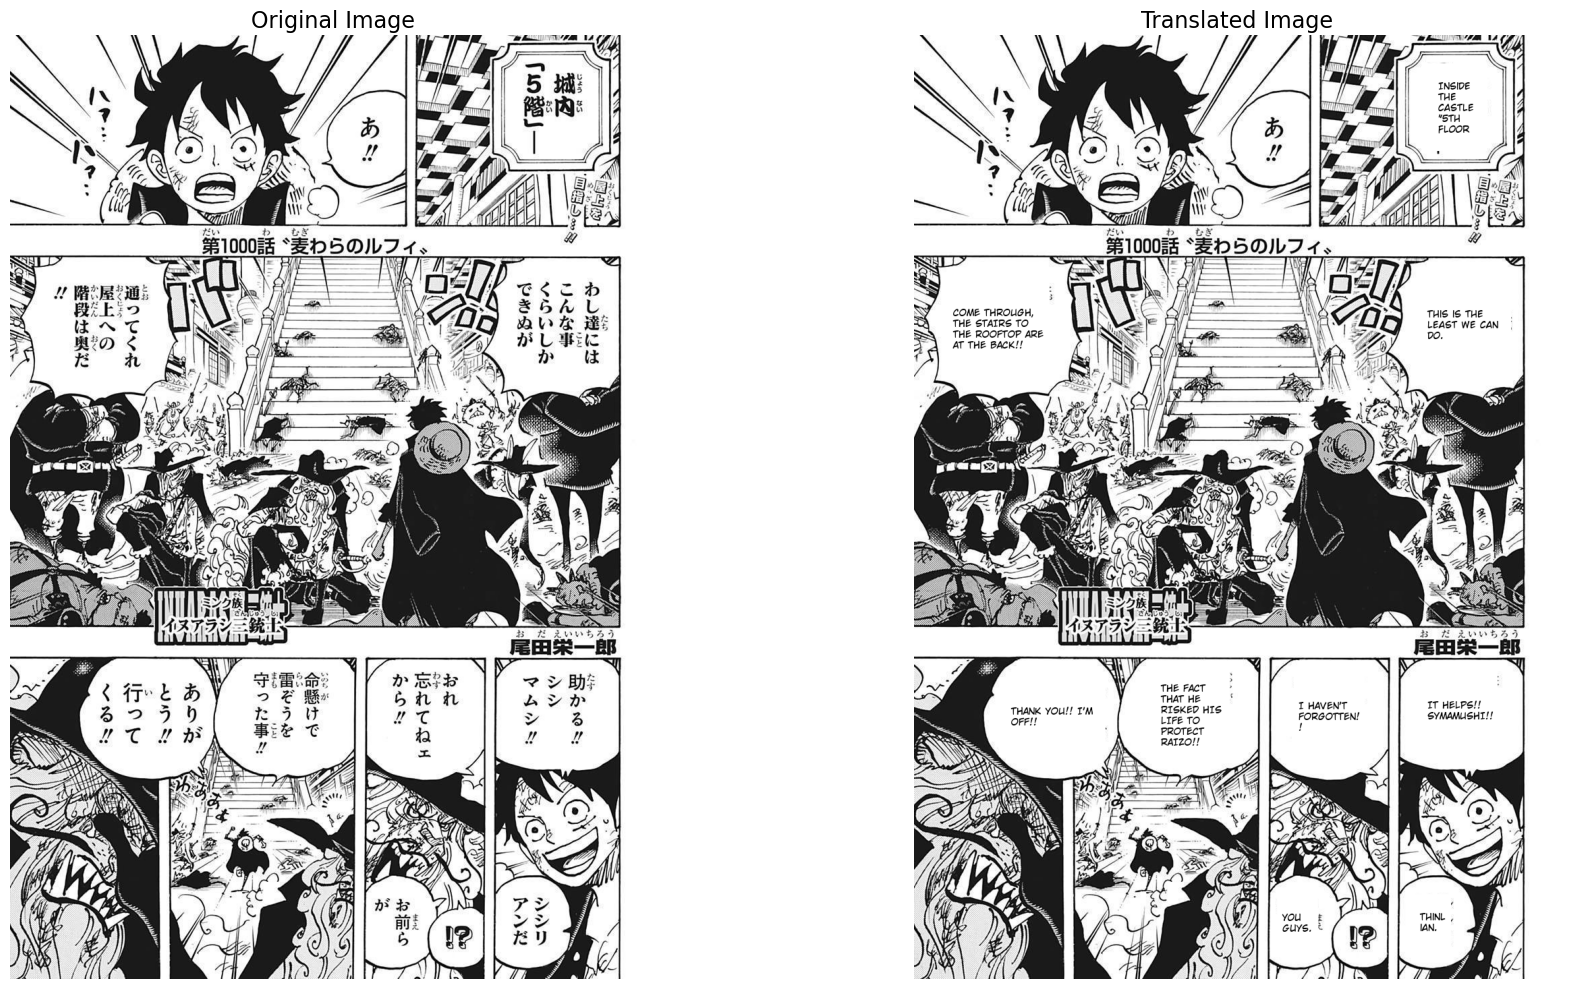

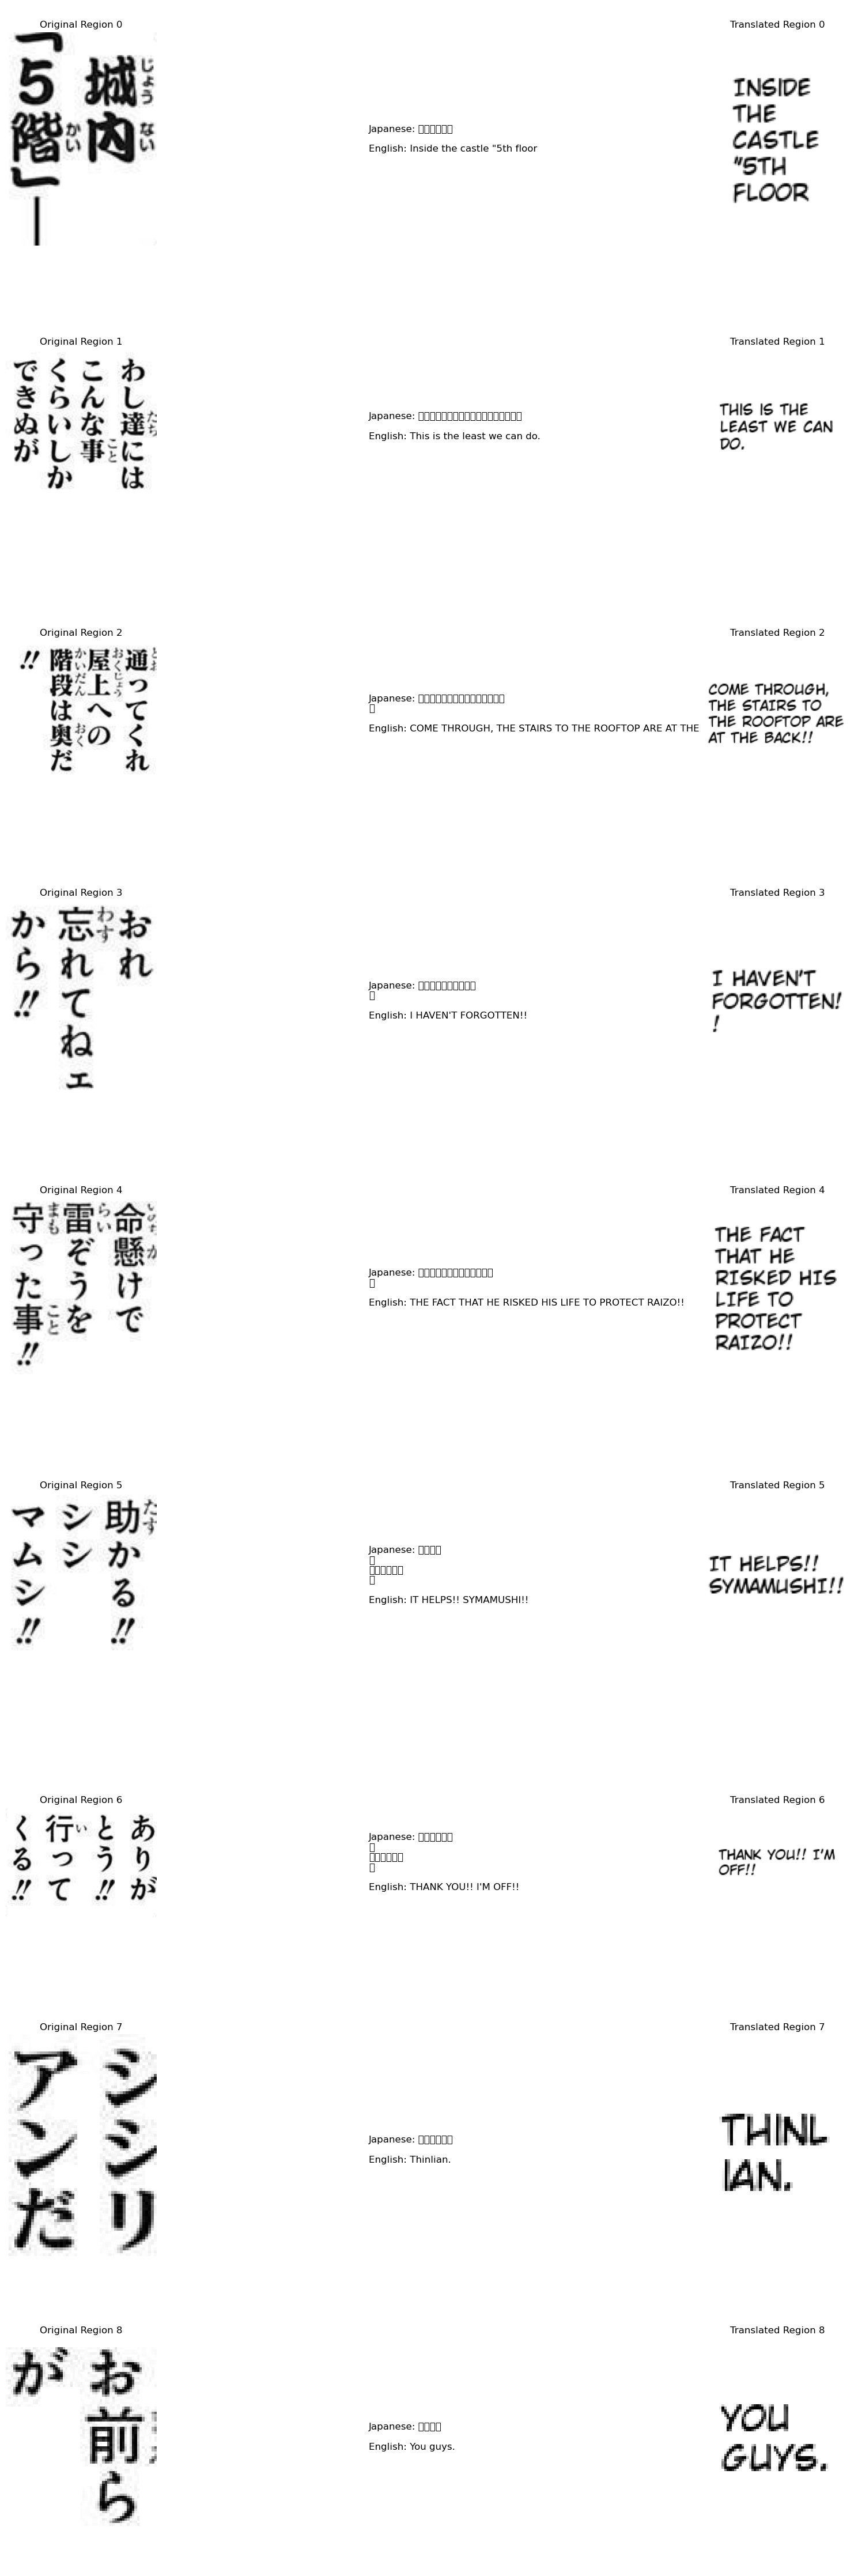

In [9]:
def insert_translation(image, box_coords, translated_text, font_path='font/CC Wild Words Roman.ttf', 
                      font_size_multiplier=1.0):
    """
    Insert translated text into a text region with more dynamic font sizing.
    
    This function:
    1. Calculates optimal font size based on region dimensions
    2. Handles text wrapping and positioning
    3. Applies manga-style text formatting
    4. Ensures text fits within the region
    
    Args:
        image (numpy.ndarray): Original image
        box_coords (tuple): Bounding box coordinates (x1, y1, x2, y2)
        translated_text (str): Text to insert
        font_path (str): Path to font file
        font_size_multiplier (float): Multiplier for font size adjustment
        
    Returns:
        numpy.ndarray: Image with inserted text
    """
    x1, y1, x2, y2 = map(int, box_coords)
    region_width, region_height = x2-x1, y2-y1
    
    # Extract the region
    region = image[y1:y2, x1:x2].copy()
    
    # Create a clean white background
    clean_region = np.ones_like(region) * 255
    
    # Create a PIL Image for text rendering
    pil_region = Image.fromarray(cv2.cvtColor(clean_region, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_region)
    
    # IMPROVED: More aggressive base font size calculation
    base_font_size = int(min(region_height / 4, region_width / 8))  # Increased from /6 and /12
    
    # Adjust for text length with less aggressive reduction
    text_length_factor = len(translated_text) / (region_width * region_height / 8000)  # Reduced divisor
    adjusted_font_size = int(base_font_size / (1 + text_length_factor * 0.2))  # Reduced factor from 0.25
    
    # Higher minimum and maximum sizes
    min_size = max(14, int(region_height / 12))  # Dynamic minimum size
    max_size = int(min(region_height / 3, region_width / 6))  # Increased from /4 and /8
    
    # Apply font size multiplier and ensure reasonable size
    font_size = max(min_size, min(int(adjusted_font_size * font_size_multiplier * 1.2), max_size))  # Added 20% increase
    
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        logging.warning(f"Font {font_path} not found, using default font")
        font = ImageFont.load_default()
    
    # Reduced padding to allow for larger text
    padding_x = int(region_width * 0.04)  # Reduced from 0.05
    padding_y = int(region_height * 0.04)  # Reduced from 0.05
    
    # Calculate effective dimensions for text
    effective_width = region_width - (2 * padding_x)
    effective_height = region_height - (2 * padding_y)
    
    # More generous character fitting
    avg_char_width = font_size * 0.6  # Increased from 0.55
    chars_per_line = int((effective_width * 0.95) / avg_char_width)  # Increased from 0.9

    def smart_wrap(text, width):
        """
        Wrap text with better handling of long words.
        
        This function:
        1. Handles long words by breaking them with hyphens
        2. Ensures text fits within specified width
        3. Maintains readability
        
        Args:
            text (str): Text to wrap
            width (int): Maximum width in characters
            
        Returns:
            str: Wrapped text
        """
        wrapped = textwrap.fill(text, width=width)
        lines = wrapped.split('\n')
        max_line_length = max([len(line) for line in lines]) if lines else 0
        
        if max_line_length > width * 1.2:
            new_lines = []
            for line in lines:
                if len(line) > width * 1.2:
                    words = line.split()
                    new_line = ""
                    for word in words:
                        if len(word) > width // 2:
                            parts = [word[i:i+width//2] for i in range(0, len(word), width//2)]
                            new_line += " " + "-".join(parts)
                        else:
                            new_line += " " + word
                    new_lines.append(new_line.strip())
                else:
                    new_lines.append(line)
            wrapped = "\n".join(new_lines)
            wrapped = textwrap.fill(wrapped, width=width)
        return wrapped
    
    # Wrap text
    wrapped_text = smart_wrap(translated_text, width=max(1, chars_per_line))
    
    # Calculate text position
    text_bbox = draw.textbbox((0, 0), wrapped_text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Adjust if text is too tall
    if text_height > effective_height:
        reduction_factor = effective_height / text_height
        new_font_size = max(min_size, int(font_size * reduction_factor * 0.95))
        font = ImageFont.truetype(font_path, new_font_size)
        wrapped_text = smart_wrap(translated_text, width=max(1, chars_per_line))
        text_bbox = draw.textbbox((0, 0), wrapped_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
    
    # Center the text
    text_x = (region_width - text_width) // 2
    text_y = (region_height - text_height) // 2
    
    # Draw text
    draw.text((text_x, text_y), wrapped_text, font=font, fill=(0, 0, 0))
    
    # Convert back to OpenCV format
    result_region = cv2.cvtColor(np.array(pil_region), cv2.COLOR_RGB2BGR)
    
    # Update the image
    image[y1:y2, x1:x2] = result_region
    
    return image

def check_and_fix_truncated_text(image, region_translations):
    """
    Enhanced function to fix text issues with better detection and handling for text class regions.
    
    This function:
    1. Analyzes text regions for potential issues
    2. Calculates optimal font sizes
    3. Prioritizes regions needing attention
    4. Applies fixes with appropriate parameters
    
    Args:
        image (numpy.ndarray): Original image
        region_translations (dict): Dictionary of region translations
        
    Returns:
        numpy.ndarray: Image with fixed text regions
    """
    fixed_image = image.copy()
    
    # First pass: analyze all text regions
    text_regions = []
    
    for region_id, data in region_translations.items():
        # Skip regions without translations
        if not data['translation'].strip():
            continue
            
        x1, y1, x2, y2 = map(int, data['coords'])
        translation = data['translation']
        
        # Calculate region properties
        region_width = x2 - x1
        region_height = y2 - y1
        region_area = region_width * region_height
        text_length = len(translation)
        chars_per_area = text_length / max(1, region_area)
        
        # Check for potential issues
        is_small_region = region_area < 15000
        is_wide_region = region_width > region_height * 1.5
        is_tall_region = region_height > region_width * 1.5
        is_dense_text = chars_per_area > 0.002
        
        # Determine appropriate font size multiplier and priority
        font_multiplier = 1.0
        priority = 0
        
        if is_small_region:
            # Small regions need larger text
            font_multiplier = 1.25
            priority = 3
        elif is_wide_region and is_dense_text:
            # Wide regions with dense text need special handling
            font_multiplier = 1.2
            priority = 2
        elif is_tall_region:
            # Tall regions need smaller text to fit vertically
            font_multiplier = 0.9
            priority = 2
        elif is_dense_text:
            # Dense text needs slight adjustment
            font_multiplier = 0.95
            priority = 1
        
        # Add to list of regions to process
        text_regions.append({
            'region_id': region_id,
            'data': data,
            'font_multiplier': font_multiplier,
            'priority': priority,
            'area': region_area
        })
    
    # Sort by priority (highest first) and then by area (smallest first)
    text_regions.sort(key=lambda x: (x['priority'], -x['area']), reverse=True)
    
    # Second pass: fix text regions
    for region in text_regions:
        region_id = region['region_id']
        data = region['data']
        font_multiplier = region['font_multiplier']
        
        # Apply the fix with appropriate parameters
        fixed_image = insert_translation(
            fixed_image, 
            data['coords'], 
            data['translation'],
            font_path='font/CC Wild Words Roman.ttf',
            font_size_multiplier=font_multiplier
        )
    
    return fixed_image

# Create a copy of the original image to modify
translated_image = image.copy()

# Create directory for translated images
translated_dir = "translated_images"
os.makedirs(translated_dir, exist_ok=True)

# Insert translations for each region
logging.info(f"Inserting translations for {len(region_translations)} regions")
for region_id, data in region_translations.items():
    if not data['translation'].strip():
        logging.warning(f"Skipping region {region_id}: empty translation")
        continue
    
    # Get coordinates
    box_coords = data['coords']
    
    # Apply translation
    translated_image = insert_translation(
        translated_image, 
        box_coords, 
        data['translation'], 
        font_path='font/CC Wild Words Roman.ttf'
    )
    
    logging.info(f"Region {region_id}: Translation inserted")

# Post-processing to fix any truncated text
translated_image = check_and_fix_truncated_text(translated_image, region_translations)

# Save the translated image
output_path = os.path.join(translated_dir, f"translated_{os.path.basename(image_path)}")
cv2.imwrite(output_path, translated_image)
logging.info(f"Saved translated image to: {output_path}")

# Display results
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image", fontsize=16)
plt.axis('off')

# Translated image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(translated_image, cv2.COLOR_BGR2RGB))
plt.title("Translated Image", fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(translated_dir, "comparison.png"), dpi=300)
plt.show()

# Show individual regions
plt.figure(figsize=(15, 5 * len(region_translations)))

for i, (region_id, data) in enumerate(region_translations.items()):
    if not data['translation'].strip():
        continue
        
    x1, y1, x2, y2 = map(int, data['coords'])
    
    # Original region
    plt.subplot(len(region_translations), 3, i*3 + 1)
    original_region = image[y1:y2, x1:x2]
    plt.imshow(cv2.cvtColor(original_region, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Region {region_id}", fontsize=12)
    plt.axis('off')
    
    # Text content
    plt.subplot(len(region_translations), 3, i*3 + 2)
    plt.text(0.1, 0.5, f"Japanese: {data['original']}\n\nEnglish: {data['translation']}", 
             fontsize=12, wrap=True, verticalalignment='center')
    plt.axis('off')
    
    # Translated region
    plt.subplot(len(region_translations), 3, i*3 + 3)
    translated_region = translated_image[y1:y2, x1:x2]
    plt.imshow(cv2.cvtColor(translated_region, cv2.COLOR_BGR2RGB))
    plt.title(f"Translated Region {region_id}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(translated_dir, "region_comparison.png"), dpi=300)
plt.show()

### Bulk Processing

2025-04-25 01:48:50.258 | INFO     | manga_ocr.ocr:__init__:16 - Loading OCR model from kha-white/manga-ocr-base
2025-04-25 01:48:53.444 | INFO     | manga_ocr.ocr:__init__:28 - Using CPU
2025-04-25 01:48:53.965 | INFO     | manga_ocr.ocr:__init__:35 - OCR ready



Processing: onepiece_1.jpg

image 1/1 c:\Users\handw\Documents\Portfolio-FTDS\manga_translator_project\images\onepiece_1.jpg: 640x448 (no detections), 54.8ms
Speed: 1.8ms preprocess, 54.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 448)
No text regions found in onepiece_1.jpg

Processing: onepiece_10.jpg

image 1/1 c:\Users\handw\Documents\Portfolio-FTDS\manga_translator_project\images\onepiece_10.jpg: 640x448 1 text, 61.8ms
Speed: 1.7ms preprocess, 61.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


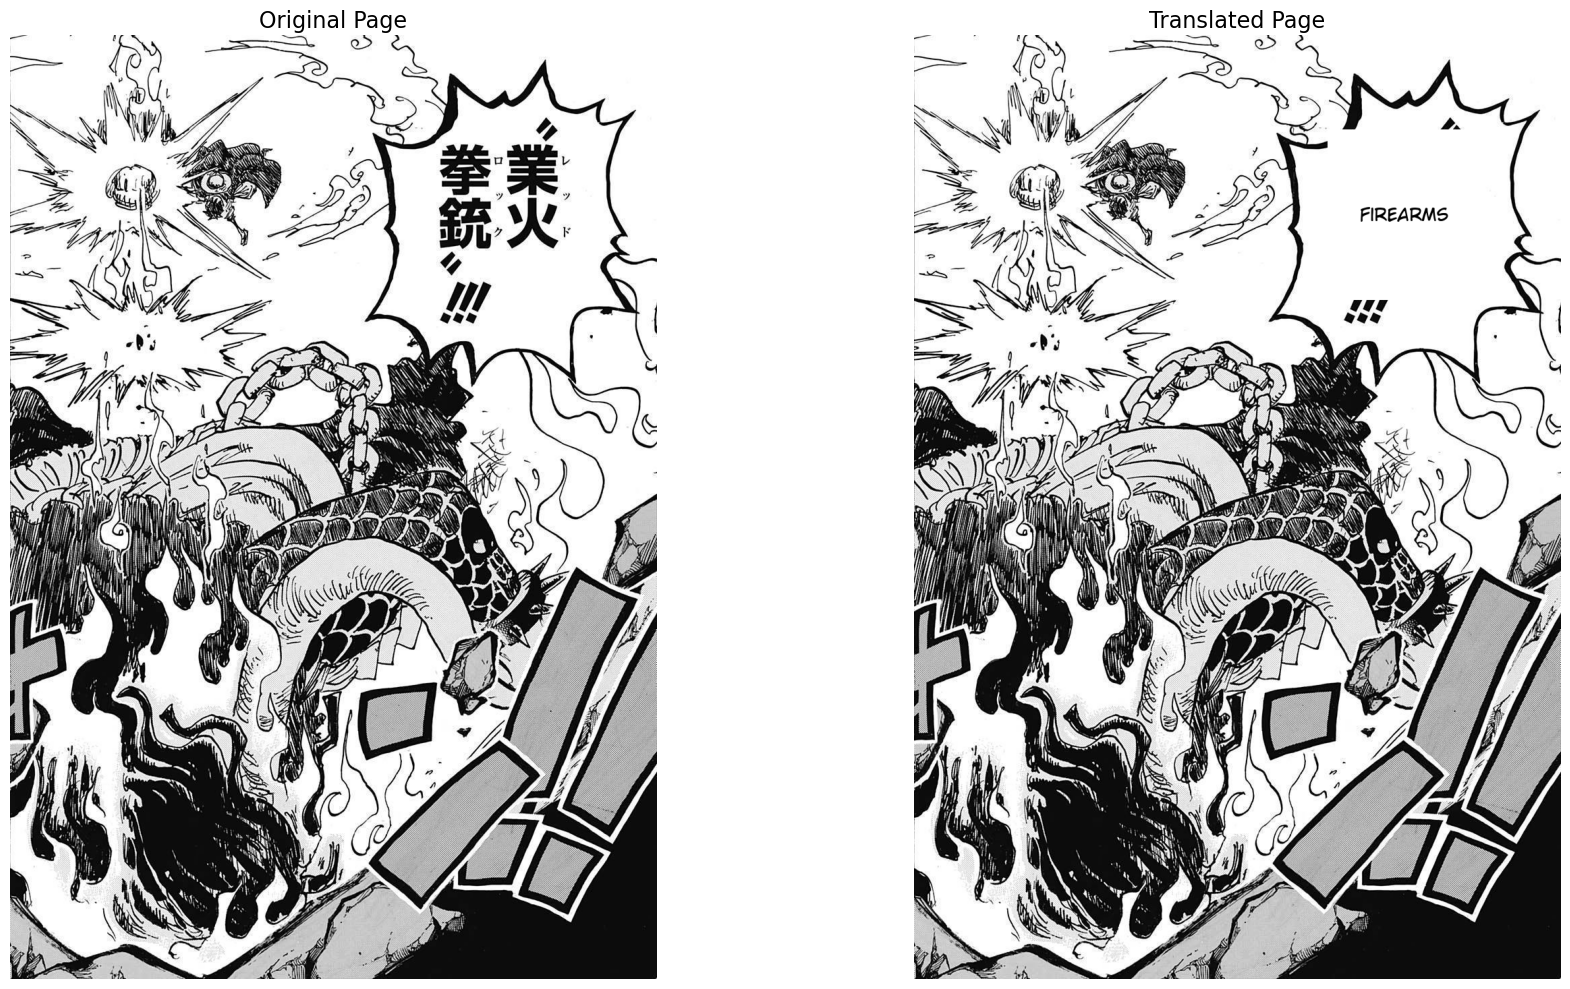


Processing: onepiece_11.jpg

image 1/1 c:\Users\handw\Documents\Portfolio-FTDS\manga_translator_project\images\onepiece_11.jpg: 640x448 6 bubbles, 7 texts, 110.1ms
Speed: 2.4ms preprocess, 110.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


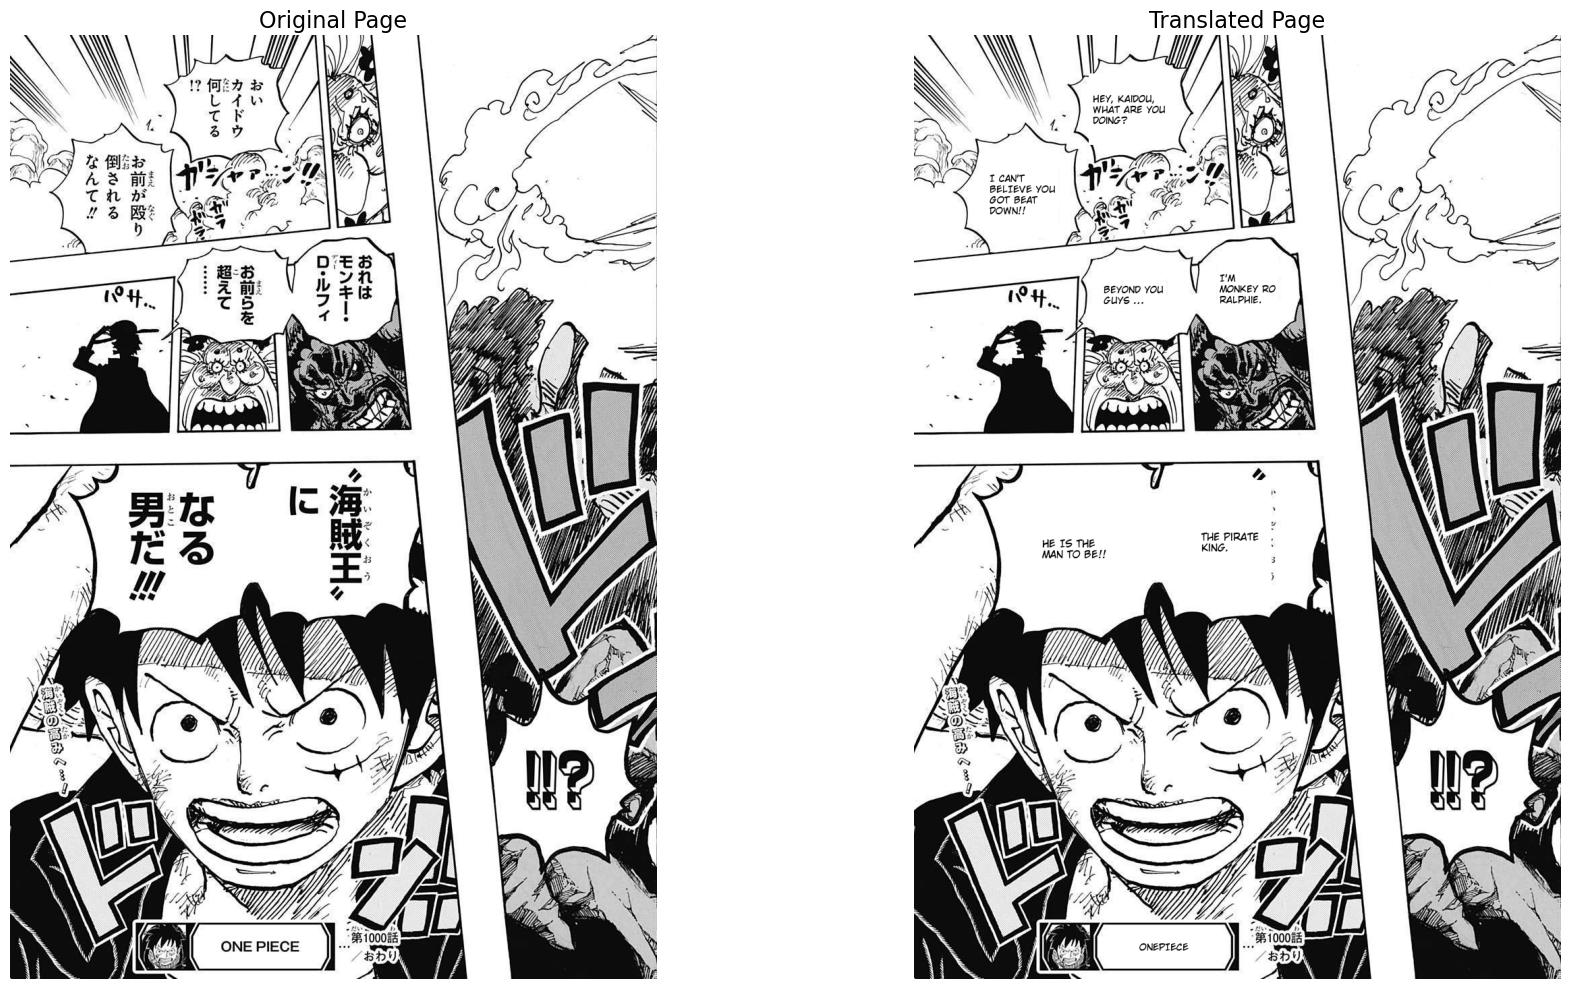


Processing: onepiece_12.jpg

image 1/1 c:\Users\handw\Documents\Portfolio-FTDS\manga_translator_project\images\onepiece_12.jpg: 640x448 2 bubbles, 1 text, 57.7ms
Speed: 2.0ms preprocess, 57.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)
No text regions found in onepiece_12.jpg

Processing: onepiece_13.jpg

image 1/1 c:\Users\handw\Documents\Portfolio-FTDS\manga_translator_project\images\onepiece_13.jpg: 640x448 12 bubbles, 10 texts, 64.9ms
Speed: 1.7ms preprocess, 64.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


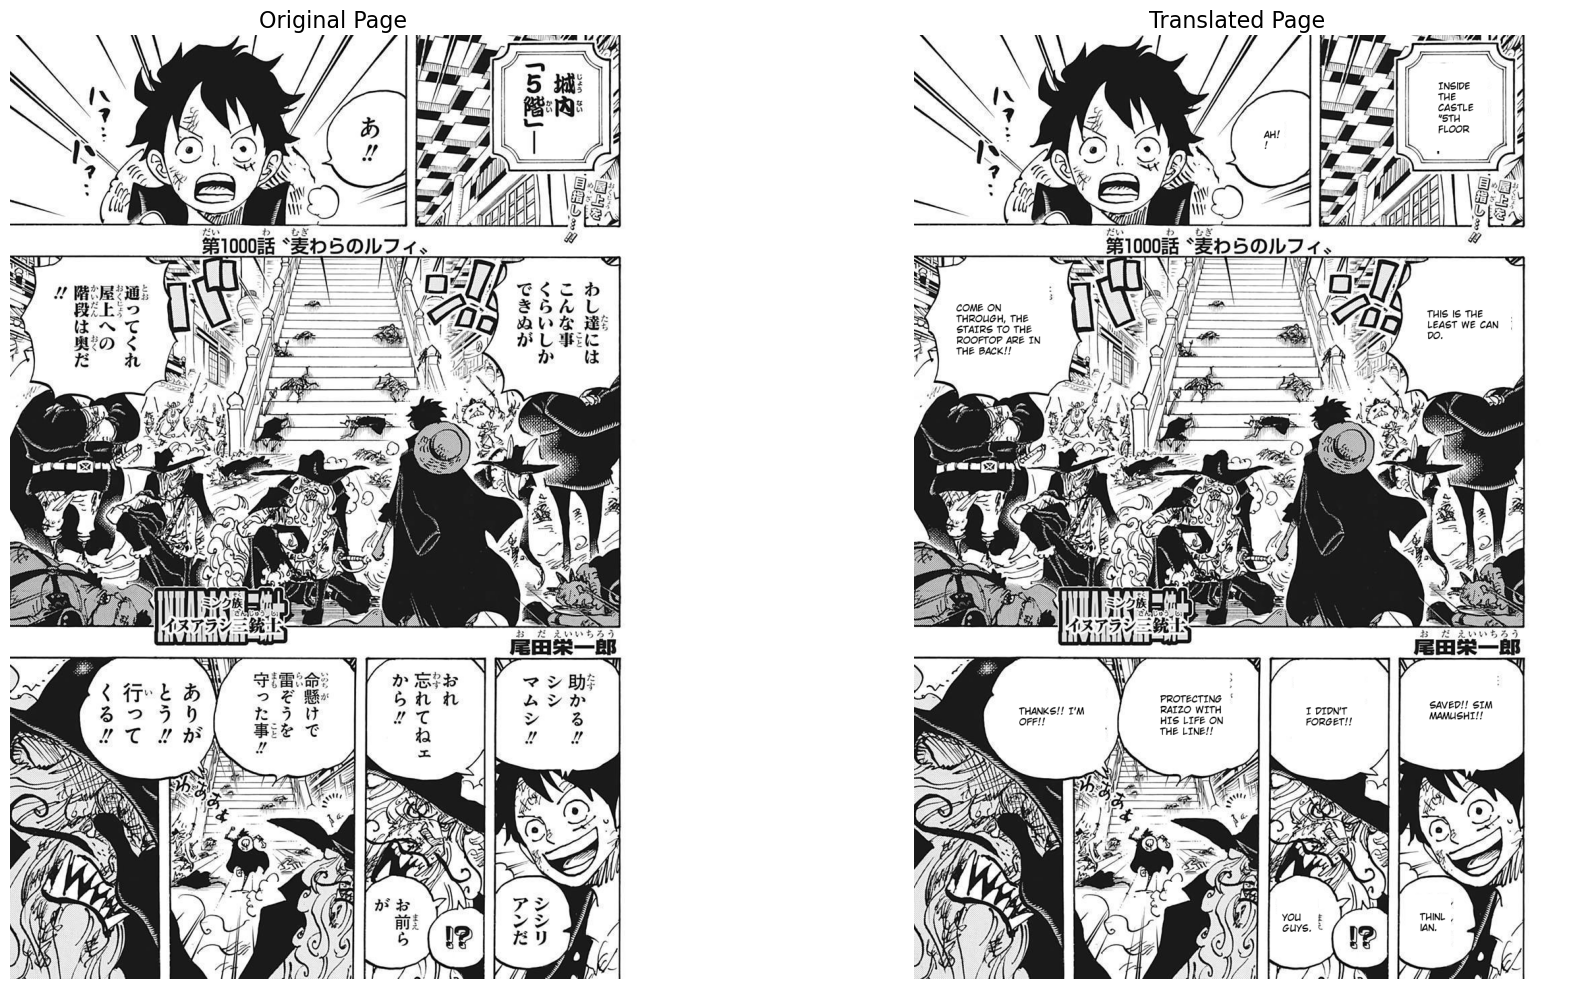

In [10]:
def process_manga_pages(image_folder, translated_dir, show_results=True):
    """
    Bulk process manga pages with complete processing for each page.
    
    This function:
    1. Processes all images in a folder
    2. Detects and extracts text regions
    3. Performs OCR and translation
    4. Inserts translations back into the images
    5. Handles errors and provides visual feedback
    
    Args:
        image_folder (str): Path to folder containing manga pages
        translated_dir (str): Path to save translated images
        show_results (bool): Whether to display processing results
        
    Returns:
        None
    """
    # Create output directory if it doesn't exist
    os.makedirs(translated_dir, exist_ok=True)
    
    # Get all image files from the folder
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process each image in the folder
    for image_file in image_files:
        try:
            image_path = os.path.join(image_folder, image_file)
            print(f"\nProcessing: {image_file}")
            
            # Load image using OpenCV
            image = cv2.imread(image_path)
            
            # Run YOLO model for text detection
            results = model(image_path)
            
            # Process detected text regions
            text_regions = []
            for i, (box, cls_id) in enumerate(zip(results[0].boxes.xyxy, results[0].boxes.cls)):
                cls_id = int(cls_id)
                
                # Only process text class (class 3)
                if cls_id != 3:
                    continue
                    
                # Extract coordinates and crop the region
                x1, y1, x2, y2 = map(int, box)
                cropped = image[y1:y2, x1:x2]
                
                # Convert to PIL Image for OCR
                pil_crop = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
                text = mocr(pil_crop)
                
                if text.strip():
                    # Clean and translate the extracted text
                    cleaned_text = clean_ocr_text(text)
                    translation = clean_and_translate_text(cleaned_text)
                    
                    if translation:
                        text_regions.append({
                            'coords': (x1, y1, x2, y2),
                            'text': cleaned_text,
                            'translation': translation
                        })
            
            # Skip if no text regions found
            if not text_regions:
                print(f"No text regions found in {image_file}")
                continue
            
            # Create translated image
            translated_image = image.copy()
            
            # Insert translations into each region
            for region in text_regions:
                translated_image = insert_translation(
                    translated_image,
                    region['coords'],
                    region['translation'],
                    font_path='font/CC Wild Words Roman.ttf'
                )
            
            # Convert text_regions list to format expected by check_and_fix_truncated_text
            region_translations = {
                i: {
                    'coords': region['coords'],
                    'translation': region['translation']
                }
                for i, region in enumerate(text_regions)
            }
            
            # Fix any truncated text
            translated_image = check_and_fix_truncated_text(translated_image, region_translations)
            
            # Save the translated image
            output_path = os.path.join(translated_dir, f"translated_{image_file}")
            cv2.imwrite(output_path, translated_image)
            
            # Display the comparison if requested
            if show_results:
                plt.figure(figsize=(20, 10))
                
                # Original image
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Original Page", fontsize=16)
                plt.axis('off')
                
                # Translated image
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(translated_image, cv2.COLOR_BGR2RGB))
                plt.title("Translated Page", fontsize=16)
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
            
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")
            continue

# Initialize OCR model (do this once)
mocr = MangaOcr()

# Main execution
logging.getLogger().setLevel(logging.ERROR)  # Suppress logging
image_folder = "images"
translated_dir = "translated_images"
process_manga_pages(image_folder, translated_dir)